# Business Objective:
### Predict the apple stock market price for next 30 days. 
There are Open, High, Low and Close price has been given for each day starting from 2012 to 2019 for Apple stock. 
+ Split the last year into a test set- can you build a model to predict stock price?
+ Find trends in short term, or long term trends?
+ Understand how it is impacted from external factors or any big external events?
+ Forecast for next 30 days.

In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
from plotly import graph_objs as go
from statsmodels.graphics.tsaplots import quarter_plot,month_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from math import sqrt
from datetime import date
from datetime import datetime
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
import pickle
import warnings
warnings.filterwarnings('ignore')

In [2]:
#reading the data 
data = pd.read_csv("AAPL.csv")
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2012-01-03,58.485714,58.928570,58.428570,58.747143,50.765709,75555200
1,2012-01-04,58.571430,59.240002,58.468571,59.062859,51.038536,65005500
2,2012-01-05,59.278572,59.792858,58.952858,59.718571,51.605175,67817400
3,2012-01-06,59.967144,60.392857,59.888573,60.342857,52.144630,79573200
4,2012-01-09,60.785713,61.107143,60.192856,60.247143,52.061932,98506100
...,...,...,...,...,...,...,...
2006,2019-12-23,280.529999,284.250000,280.369995,284.000000,282.054138,24643000
2007,2019-12-24,284.690002,284.890015,282.920013,284.269989,282.322266,12119700
2008,2019-12-26,284.820007,289.980011,284.700012,289.910004,287.923645,23280300
2009,2019-12-27,291.119995,293.970001,288.119995,289.799988,287.814392,36566500


# Data Preprocessing :

#Transform Date to datetime object and Set as Index :

In [3]:
data.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

In [4]:
data.Date = pd.to_datetime(data.Date)
data.dtypes

Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume                int64
dtype: object

In [5]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2012-01-03,58.485714,58.928570,58.428570,58.747143,50.765709,75555200
1,2012-01-04,58.571430,59.240002,58.468571,59.062859,51.038536,65005500
2,2012-01-05,59.278572,59.792858,58.952858,59.718571,51.605175,67817400
3,2012-01-06,59.967144,60.392857,59.888573,60.342857,52.144630,79573200
4,2012-01-09,60.785713,61.107143,60.192856,60.247143,52.061932,98506100


In [6]:
df = data.copy()
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2012-01-03,58.485714,58.928570,58.428570,58.747143,50.765709,75555200
1,2012-01-04,58.571430,59.240002,58.468571,59.062859,51.038536,65005500
2,2012-01-05,59.278572,59.792858,58.952858,59.718571,51.605175,67817400
3,2012-01-06,59.967144,60.392857,59.888573,60.342857,52.144630,79573200
4,2012-01-09,60.785713,61.107143,60.192856,60.247143,52.061932,98506100


In [7]:
df.set_index('Date',inplace=True)

In [8]:
df.index

DatetimeIndex(['2012-01-03', '2012-01-04', '2012-01-05', '2012-01-06',
               '2012-01-09', '2012-01-10', '2012-01-11', '2012-01-12',
               '2012-01-13', '2012-01-17',
               ...
               '2019-12-16', '2019-12-17', '2019-12-18', '2019-12-19',
               '2019-12-20', '2019-12-23', '2019-12-24', '2019-12-26',
               '2019-12-27', '2019-12-30'],
              dtype='datetime64[ns]', name='Date', length=2011, freq=None)

In [9]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-03,58.485714,58.928570,58.428570,58.747143,50.765709,75555200
2012-01-04,58.571430,59.240002,58.468571,59.062859,51.038536,65005500
2012-01-05,59.278572,59.792858,58.952858,59.718571,51.605175,67817400
2012-01-06,59.967144,60.392857,59.888573,60.342857,52.144630,79573200
2012-01-09,60.785713,61.107143,60.192856,60.247143,52.061932,98506100


# Check for Holidays:

In [10]:
data.head(1).index, data.tail(1).index

(RangeIndex(start=0, stop=1, step=1),
 RangeIndex(start=2010, stop=2011, step=1))

In [11]:
d0 = date(2012,1,3)
d1 = date(2019,12,30)
days = len(pd.date_range((d0),(d1)))
print(f'The number of days from {d0} to {d1} is {days} days')
print()
bdays = len(pd.bdate_range((d0),(d1)))
print(f'The number of business days from {d0} to {d1} is {bdays} days')
print()
print(f'The number of days from {d0} to {d1} in the given time series is {len(data)} days')

The number of days from 2012-01-03 to 2019-12-30 is 2919 days

The number of business days from 2012-01-03 to 2019-12-30 is 2085 days

The number of days from 2012-01-03 to 2019-12-30 in the given time series is 2011 days


# Create CustomBusiness Day:

In [12]:
us_cal = CustomBusinessDay(calendar=USFederalHolidayCalendar())

In [13]:
my_range = pd.date_range(start='2012-01-03',end='2019-12-30',freq=us_cal)
print(my_range.difference(df.index))

DatetimeIndex(['2012-04-06', '2012-10-29', '2012-10-30', '2013-03-29',
               '2014-04-18', '2015-04-03', '2016-03-25', '2017-04-14',
               '2018-03-30', '2018-12-05', '2019-04-19'],
              dtype='datetime64[ns]', freq=None)


In [14]:
Cu = CustomBusinessDay(calendar=USFederalHolidayCalendar(),holidays=['2012-04-06', '2012-10-29', '2012-10-30', 
                                                                    '2013-03-29','2014-04-18', '2015-04-03', 
                                                                    '2016-03-25', '2017-04-14', '2018-03-30', 
                                                                    '2018-12-05', '2019-04-19'])
my_range = pd.date_range(start='2012-01-03',end='2019-12-30',freq=Cu)
print(my_range.difference(df.index))

DatetimeIndex([], dtype='datetime64[ns]', freq=None)


In [15]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-03,58.485714,58.928570,58.428570,58.747143,50.765709,75555200
2012-01-04,58.571430,59.240002,58.468571,59.062859,51.038536,65005500
2012-01-05,59.278572,59.792858,58.952858,59.718571,51.605175,67817400
2012-01-06,59.967144,60.392857,59.888573,60.342857,52.144630,79573200
2012-01-09,60.785713,61.107143,60.192856,60.247143,52.061932,98506100
...,...,...,...,...,...,...
2019-12-23,280.529999,284.250000,280.369995,284.000000,282.054138,24643000
2019-12-24,284.690002,284.890015,282.920013,284.269989,282.322266,12119700
2019-12-26,284.820007,289.980011,284.700012,289.910004,287.923645,23280300


In [16]:
df = df.asfreq(Cu)

In [17]:
df.index

DatetimeIndex(['2012-01-03', '2012-01-04', '2012-01-05', '2012-01-06',
               '2012-01-09', '2012-01-10', '2012-01-11', '2012-01-12',
               '2012-01-13', '2012-01-17',
               ...
               '2019-12-16', '2019-12-17', '2019-12-18', '2019-12-19',
               '2019-12-20', '2019-12-23', '2019-12-24', '2019-12-26',
               '2019-12-27', '2019-12-30'],
              dtype='datetime64[ns]', name='Date', length=1995, freq='C')

# Now the datetime index has the frequncy C.

# Exploratory Data Analysis :

#Considering only the closing price for the analysis :

In [18]:
df.drop(['Open','High','Low','Adj Close','Volume'],axis=1,inplace=True)
df.head()

,Close
Date,
2012-01-03,58.747143
2012-01-04,59.062859
2012-01-05,59.718571
2012-01-06,60.342857
2012-01-09,60.247143


# Downsampling the data to Monthly :

In [19]:
df_m = df.resample('M').mean()
df_m.head(),df_m.tail()

(                Close
 Date                 
 2012-01-31  61.225428
 2012-02-29  71.081572
 2012-03-31  82.501104
 2012-04-30  86.571857
 2012-05-31  80.667597,
                  Close
 Date                  
 2019-08-31  204.957728
 2019-09-30  217.994999
 2019-10-31  235.260000
 2019-11-30  262.537371
 2019-12-31  275.669496)

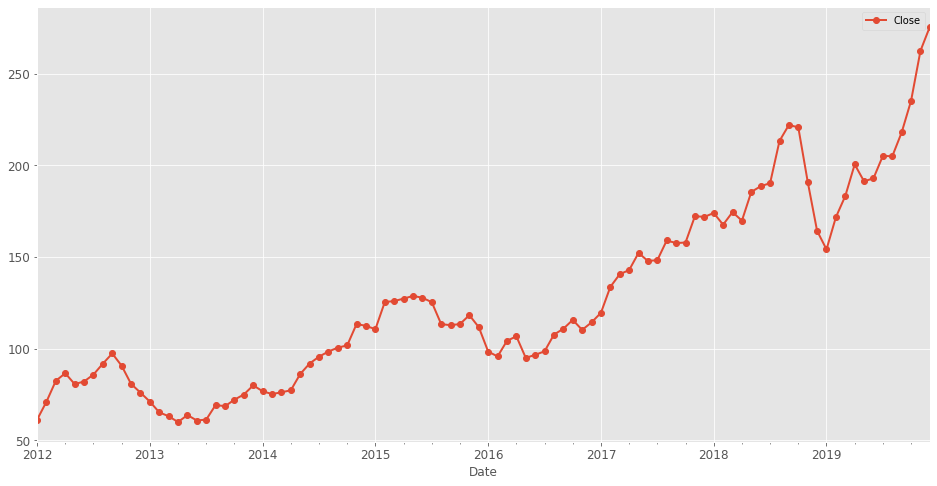

In [20]:
df_m.plot(figsize=(16,8), linewidth=2,marker='o', fontsize=12);

# Seasonal-Trend Decomposition using LOESS (STL) :

In [21]:
stl = STL(df_m)
result = stl.fit()

In [22]:
seasonal, trend, resid = result.seasonal, result.trend, result.resid

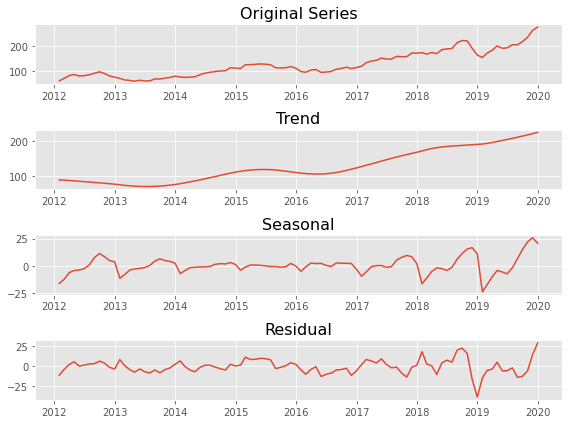

In [23]:
plt.figure(figsize=(8,6))

plt.subplot(4,1,1)
plt.plot(df_m)
plt.title('Original Series', fontsize=16)

plt.subplot(4,1,2)
plt.plot(trend)
plt.title('Trend', fontsize=16)

plt.subplot(4,1,3)
plt.plot(seasonal)
plt.title('Seasonal', fontsize=16)

plt.subplot(4,1,4)
plt.plot(resid)
plt.title('Residual', fontsize=16)

plt.tight_layout()

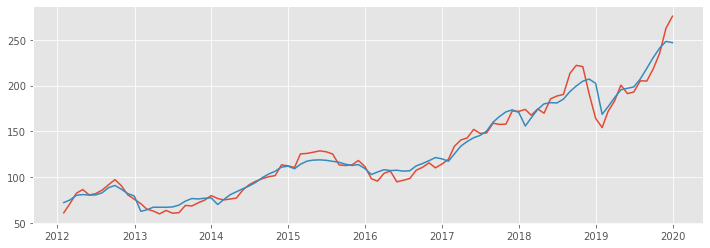

In [24]:
estimated = trend + seasonal
plt.figure(figsize=(12,4))
plt.plot(df_m)
plt.plot(estimated);

In [25]:
resid_mu = resid.mean()
resid_dev = resid.std()

lower = resid_mu - 3*resid_dev
upper = resid_mu + 3*resid_dev

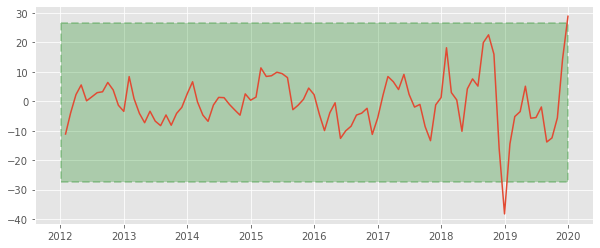

In [26]:
plt.figure(figsize=(10,4))
plt.plot(resid)

plt.fill_between([datetime(2012,1,3), datetime(2019,12,30)], lower, upper, color='g', alpha=0.25, linestyle='--', linewidth=2);

# There is anomaly in the months of December of 2018 and 2019 on the lower and upper side.

# Check for Seasonality :

# Seasonal Decomposition plot :

# Components of Seasonal Decompositon plot :

1.Trend — the general direction of the series over a long period of time.

2.Seasonality — a distinct, repeating pattern observed in regular intervals due to various seasonal factors.

3.Residual — the irregular component consisting of the fluctuations in the time series after removing the previous components.

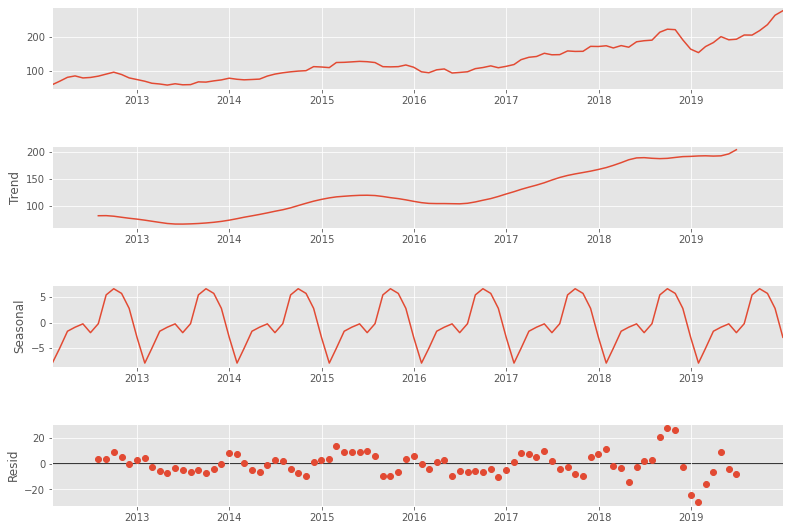

In [27]:
seas_add = seasonal_decompose(df_m, model='additive')
seas_add.plot()
plt.gcf().set_size_inches(12, 8);


# Repeating patterns are seen here. Seasonality refers to predictable changes that occur over a one-year period in a business or economy based on the seasons including calendar or commercial seasons.

# Seasonal Subseries Plot :

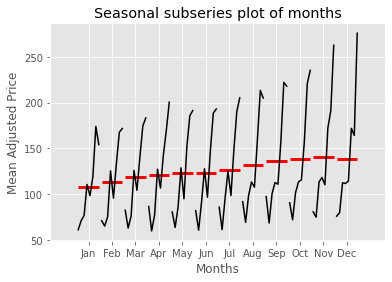

In [28]:
month_plot(df['Close'].resample('M').mean())
plt.title('Seasonal subseries plot of months')
plt.xlabel('Months')
plt.ylabel('Mean Adjusted Price')
plt.show()

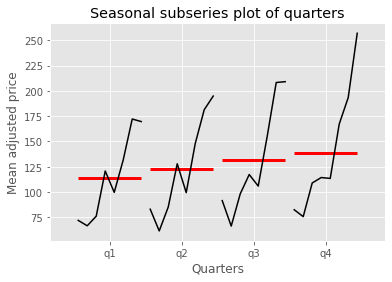

In [29]:
quarter_plot(df['Close'].resample('Q').mean())
plt.title('Seasonal subseries plot of quarters')
plt.xlabel('Quarters')
plt.ylabel('Mean adjusted price')
plt.show()

# The quarter plot shows the seasonality more clearly than the month plot.

# Testing For Stationarity

In [30]:
from statsmodels.tsa.stattools import adfuller

In [31]:
def test_stationarity(series):
    
    #Determine rolling statistics
    movingAverage = series.rolling(window=8).mean()
    movingSD = series.rolling(window=8).std()
    
    #Plot rolling statistics
    plt.plot(series, color='blue', label='Original')
    plt.plot(movingAverage, color='red', label='Rolling Mean')
    plt.plot(movingSD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #ad-fuller test
    stat_test = adfuller(series,autolag='AIC')
    print('Results of Dickey Fuller Test:')
    print()
    print('Test Statistic : ',stat_test[0])
    print('p value : ',stat_test[1])
    print('Number of Lags : ',stat_test[2])
    print('Critical values : ')
    for key, val in stat_test[4].items():
        print('\t',key, ': ',val)
    print()    
    if stat_test[1] > 0.05:
        print('Series is non-stationary')
    else:
        print('Series is stationary')

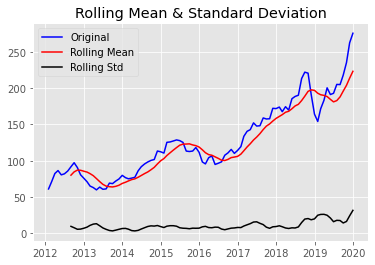

Results of Dickey Fuller Test:

Test Statistic :  0.5119654984597609
p value :  0.9852322761789654
Number of Lags :  1
Critical values : 
	 1% :  -3.5019123847798657
	 5% :  -2.892815255482889
	 10% :  -2.583453861475781

Series is non-stationary


In [32]:
test_stationarity(df_m)

# Observation :

The graph of rolling mean and standard deviation are not constant.

The p value is greater than 0.05 and the test statistic is more than the critical values. This suggests that we cannot reject the null hypothesis which means that the process has unit root, and the time series is non-stationary that has the time-dependent structure.

The series is non-stationary.

# Check the order of non-seasonal differencing needed using pmdarima and Differencing the time series :

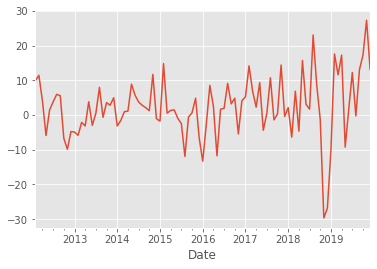

In [33]:
dfm_lag = df_m['Close'].rolling(window=2).apply(lambda x: x.iloc[1] - x.iloc[0]).dropna()
dfm_lag.plot();

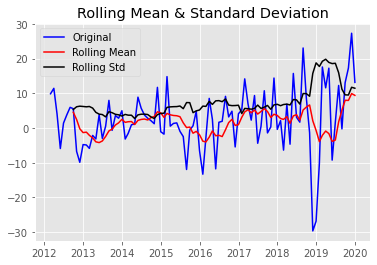

Results of Dickey Fuller Test:

Test Statistic :  -6.549178388231945
p value :  8.940119318440014e-09
Number of Lags :  0
Critical values : 
	 1% :  -3.5019123847798657
	 5% :  -2.892815255482889
	 10% :  -2.583453861475781

Series is stationary


In [34]:
test_stationarity(dfm_lag)

# Observation :

The graph of rolling mean and standard deviation are constant.

The p value is very low and the test statistic is less than 1% critical value. This suggests that we can reject the null hypothesis with a significance level of less than 1% (i.e. a low probability that the result is a statistical fluke).

Rejecting the null hypothesis means that the process has no unit root, and in turn that the time series is stationary or does not have time-dependent structure.

# The series is trend stationary now.

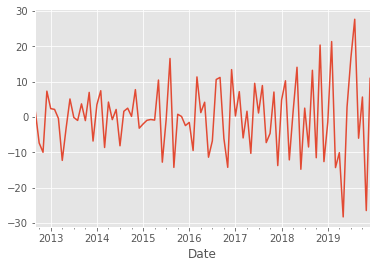

In [35]:
dfm_lag_se = dfm_lag.rolling(window=8).apply(lambda x: x.iloc[1] - x.iloc[0]).dropna()
dfm_lag_se.plot();

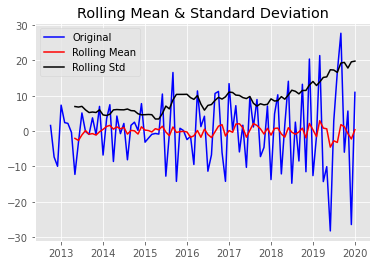

Results of Dickey Fuller Test:

Test Statistic :  -5.983007792223128
p value :  1.8196351010035577e-07
Number of Lags :  7
Critical values : 
	 1% :  -3.5148692050781247
	 5% :  -2.8984085156250003
	 10% :  -2.58643890625

Series is stationary


In [36]:
test_stationarity(dfm_lag_se)

# ACF and PACF plots :

# Autocorrelation function (ACF): At lag k, this is the correlation between series values that are k intervals apart.

#Partial autocorrelation function (PACF): At lag k, this is the correlation between series values that are k intervals apart, accounting for the values of the intervals between.

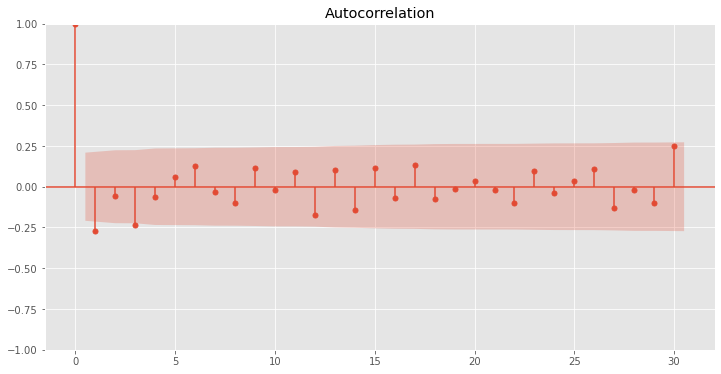

In [37]:
fig, ax = plt.subplots(figsize=(12,6))
acf = plot_acf(dfm_lag_se,lags=30,ax=ax)

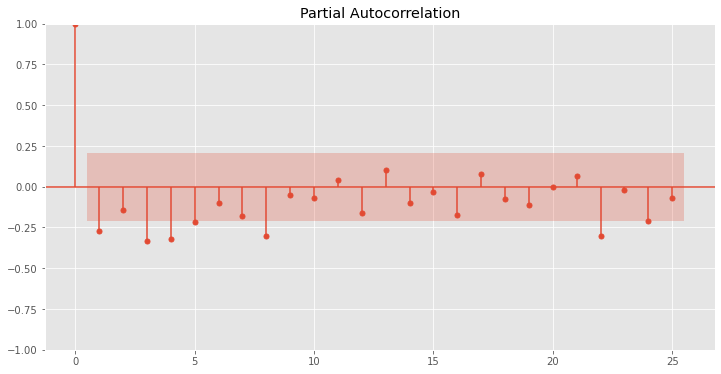

In [38]:
fig, ax = plt.subplots(figsize=(12,6))
pacf = plot_pacf(dfm_lag_se,lags=25,ax=ax)

# Observation :

From the above plot we can see that,the ACF & PACF plot start with a lag zero(0) which is the correlation of the time series with itself & therefore results in correlation of 1 .

You can see that a blue area in the ACF & PACF plots indicate the 95% confidence interval & Is an indicator of the significant threshold.

From the plot we choose p=1 & q=1

# Dividing the data into train and testing , last year data as a test data and remaning as traning data

In [39]:
train = df.iloc[:len(df)-249]

# Taking last one year for testing
test = df.iloc[len(df)-249:]
test.head(),test.tail()

(                 Close
 Date                  
 2019-01-02  157.919998
 2019-01-03  142.190002
 2019-01-04  148.259995
 2019-01-07  147.929993
 2019-01-08  150.750000,
                  Close
 Date                  
 2019-12-23  284.000000
 2019-12-24  284.269989
 2019-12-26  289.910004
 2019-12-27  289.799988
 2019-12-30  291.519989)

# ARIMA MODEL

In [40]:
from statsmodels.tsa.arima_model import ARIMA

In [41]:
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

In [42]:
model = sm.tsa.arima.ARIMA(train['Close'], order=(1,1,1))
model_fit = model.fit()

In [43]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 1746
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -3621.613
Date:                Thu, 16 Feb 2023   AIC                           7249.226
Time:                        12:29:12   BIC                           7265.619
Sample:                    01-03-2012   HQIC                          7255.287
                         - 12-31-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7990      0.094     -8.474      0.000      -0.984      -0.614
ma.L1          0.8391      0.087      9.652      0.000       0.669       1.009
sigma2         3.7171      0.063     58.780      0.000       3.593       3.841
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):              3267.45
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               3.41   Skew:                            -0.43
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

From the above analysis, we can see that the P-value of ar.L1 model & ma.L1 model is 0.00 which is less than 0.05, that mean's our data has highly significant

In [44]:
start = len(train)
end = len(train)+len(test)-1
pred1 = model_fit.predict(start=start,end=end,type='levels')

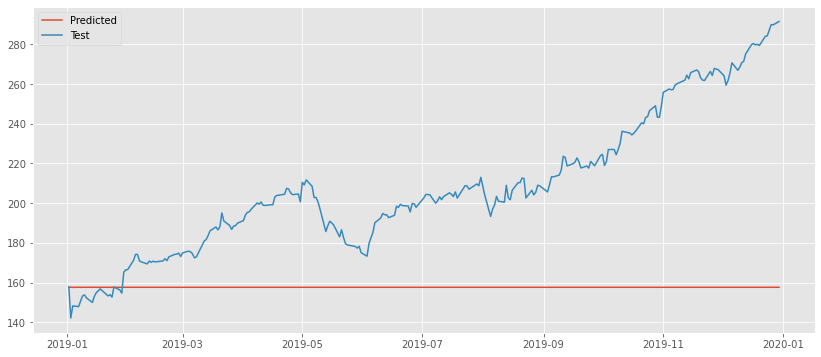

In [45]:
plt.figure(figsize=(14,6))
plt.plot(pred1, label='Predicted')
plt.plot(test, label='Test')
plt.legend(loc='best')
plt.show()

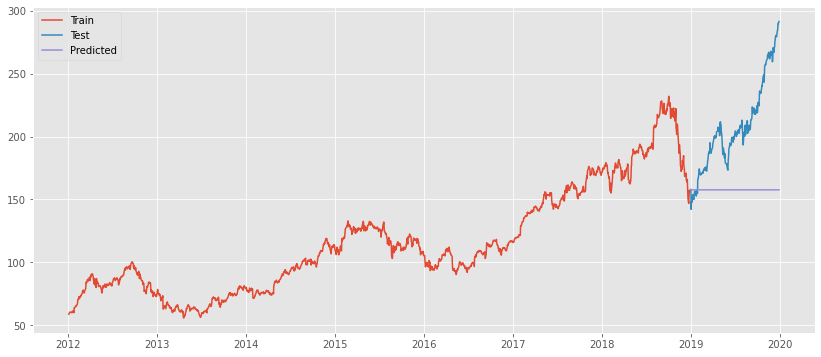

In [46]:
plt.figure(figsize=(14,6))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(pred1, label='Predicted')
plt.legend(loc='best')
plt.show()

# Checking RMSE

In [47]:
rmse = sqrt(mean_squared_error(pred1,test))

print('Root Mean Squared Error of ARIMA model =',rmse)

Root Mean Squared Error of ARIMA model = 60.429268037078565


In [48]:
test.mean()

Close    207.585462
dtype: float64

### Seasonal Differencing 

# BUILDING SARIMAX MODEL FOR MONTHLY(23days)

In [49]:
model1=sm.tsa.statespace.SARIMAX(train['Close'], order=(1,1,1),seasonal_order=(1,1,1,23))
model1_fit=model1.fit()

In [50]:
model1_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Close   No. Observations:                 1746
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 23)   Log Likelihood               -3624.281
Date:                            Thu, 16 Feb 2023   AIC                           7258.561
Time:                                    12:29:27   BIC                           7285.818
Sample:                                01-03-2012   HQIC                          7268.645
                                     - 12-31-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9705      0.038     25.542      0.000       0.896       1.045
ma.L1         -0.9605      0.042    -23.028      0.000      -1.042      -0.879
ar.S.L23      -0.0506      0.020     -2.479      0.013      -0.091      -0.011
ma.S.L23      -1.0000      4.697     -0.213      0.831     -10.207       8.207
sigma2         3.7158     17.427      0.213      0.831     -30.440      37.872
===================================================================================
Ljung-Box (L1) (Q):                   1.66   Jarque-Bera (JB):              3278.05
Prob(Q):                              0.20   Prob(JB):                         0.00
Heteroskedasticity (H):               3.45   Skew:                            -0.45
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [51]:
pred2 = model1_fit.predict(start=start,end=end)

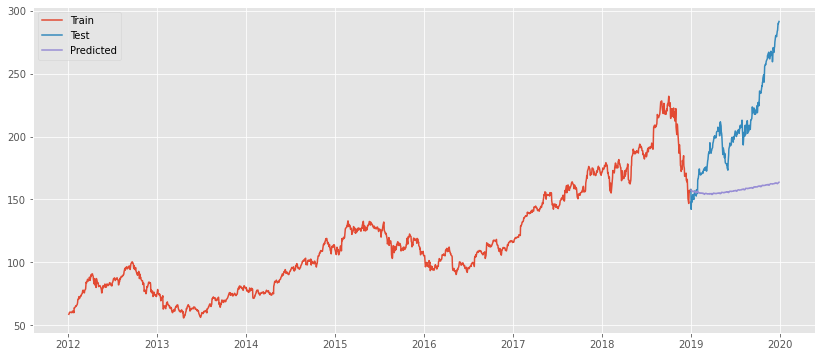

In [52]:
plt.figure(figsize=(14,6))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(pred2, label='Predicted')
plt.legend(loc='best')
plt.show()

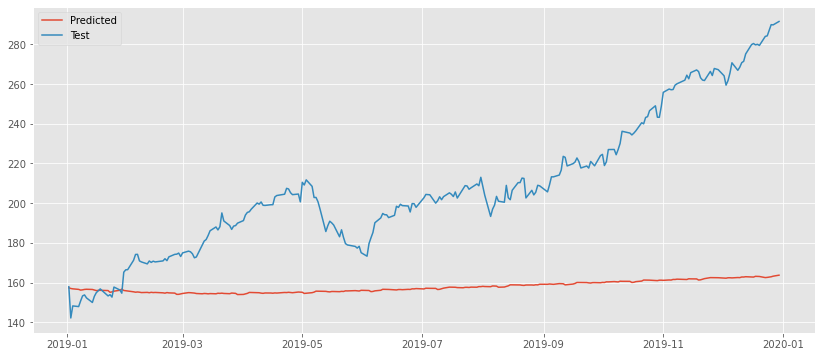

In [53]:
plt.figure(figsize=(14,6))
plt.plot(pred2, label='Predicted')
plt.plot(test, label='Test')
plt.legend(loc='best')
plt.show()

In [54]:
rmse1 = sqrt(mean_squared_error(pred2,test))

print('Root Mean Squared Error of SARIMA with Monthly Seasonality =',rmse1)

Root Mean Squared Error of SARIMA with Monthly Seasonality = 59.06152608489757


# BUILDING SARIMAX MODEL FOR QUARTERLY(63days)

In [55]:
model2=sm.tsa.statespace.SARIMAX(train['Close'], order=(1,1,1),seasonal_order=(1,1,1,63))


In [56]:
model2_fit=model2.fit()

In [57]:
model2_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Close   No. Observations:                 1746
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 63)   Log Likelihood               -3586.069
Date:                            Thu, 16 Feb 2023   AIC                           7182.139
Time:                                    12:32:43   BIC                           7209.277
Sample:                                01-03-2012   HQIC                          7192.191
                                     - 12-31-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8326      0.094     -8.875      0.000      -1.016      -0.649
ma.L1          0.8656      0.087      9.975      0.000       0.696       1.036
ar.S.L63      -0.0384      0.028     -1.382      0.167      -0.093       0.016
ma.S.L63      -0.8941      0.019    -46.492      0.000      -0.932      -0.856
sigma2         3.9097      0.074     52.941      0.000       3.765       4.054
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):              2647.98
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               3.54   Skew:                            -0.48
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [58]:
pred3 = model2_fit.predict(start=start,end=end)

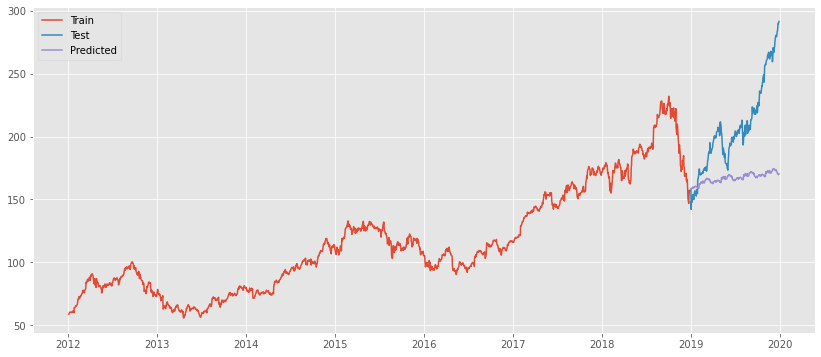

In [59]:
plt.figure(figsize=(14,6))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(pred3, label='Predicted')
plt.legend(loc='best')
plt.show()

In [60]:
rmse2 = sqrt(mean_squared_error(pred3,test))

print('Root Mean Squared Error of SARIMA with Quarterly Seasonality =',rmse2)

Root Mean Squared Error of SARIMA with Quarterly Seasonality = 51.03659558153698


# ARIMA with Seasonal order using Maximum likelihood estimation :

In [61]:
model_sea= sm.tsa.arima.ARIMA(train['Close'], order=(2,1,1),seasonal_order=(1,1,1,251))
model_sea = model_sea.fit(method='innovations_mle',low_memory=True,cov_type='none')

In [62]:
model_sea.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             Close   No. Observations:                 1746
Model:             ARIMA(2, 1, 1)x(1, 1, 1, 251)   Log Likelihood               -3331.606
Date:                           Thu, 16 Feb 2023   AIC                           6675.212
Time:                                   12:36:10   BIC                           6707.067
Sample:                               01-03-2012   HQIC                          6687.081
                                    - 12-31-2018                                         
Covariance Type:                    Not computed                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2113        nan        nan        nan         nan         nan
ar.L2         -0.0689        nan        nan        nan         nan         nan
ma.L1         -0.1841        nan        nan        nan         nan         nan
ar.S.L251      0.0856        nan        nan        nan         nan         nan
ma.S.L251     -0.7416        nan        nan        nan         nan         nan
sigma2         4.5319        nan        nan        nan         nan         nan
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1486.64
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               3.14   Skew:                            -0.37
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.83
===================================================================================

Warnings:
[1] Covariance matrix not calculated.
"""

In [63]:
pred4 = model_sea.predict(start=start,end=end,type='levels')

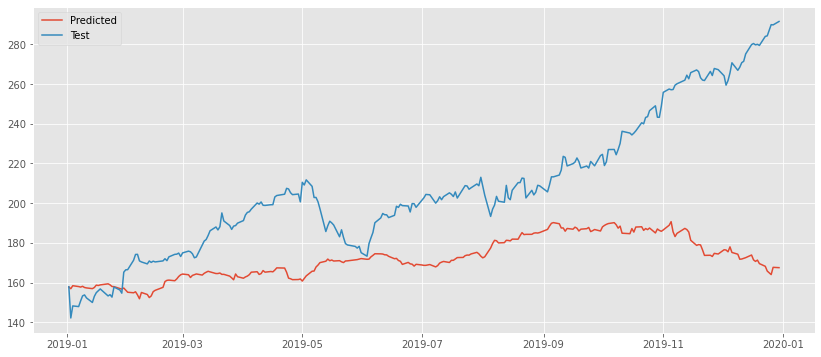

In [64]:
plt.figure(figsize=(14,6))
plt.plot(pred4, label='Predicted')
plt.plot(test, label='Test')
plt.legend(loc='best')
plt.show()

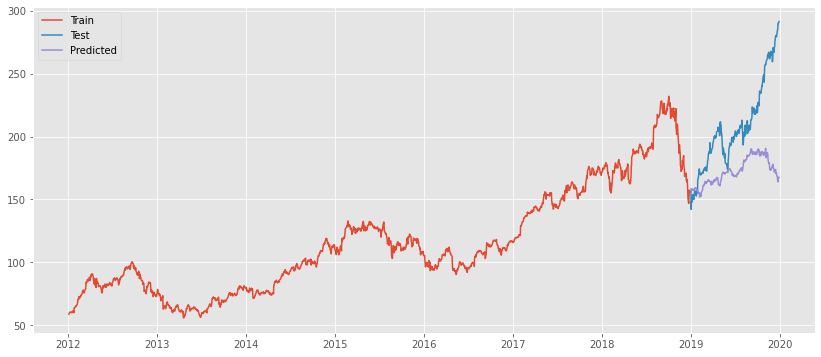

In [65]:
plt.figure(figsize=(14,6))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(pred4, label='Predicted')
plt.legend(loc='best')
plt.show()

In [66]:
rmse3 = sqrt(mean_squared_error(pred4,test))

print('Root Mean Squared Error of ARIMA with seasonal order using innovations_mle method =',rmse3)

Root Mean Squared Error of ARIMA with seasonal order using innovations_mle method = 45.86943993113131


# This model has captured seasonality and the rmse is low compared to non-seasonal arima and sarima models.

# Holt-Winters Triple Exponential Smoothing :

In [67]:
model_h = ExponentialSmoothing(train,trend='mul',seasonal='mul',seasonal_periods=251)
model_h = model_h.fit()
model_h.summary()

Dep. Variable:,Close,No. Observations:,1746
Model:,ExponentialSmoothing,SSE,5635.743
Optimized:,True,AIC,2555.966
Trend:,Multiplicative,BIC,3949.562
Seasonal:,Multiplicative,AICC,2645.087
Seasonal Periods:,251,Date:,"Thu, 16 Feb 2023"
Box-Cox:,False,Time:,12:36:20
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.9950011,alpha,True
smoothing_trend,0.0001001,beta,True


In [68]:
pred5 = model_h.predict(start=start,end=end)

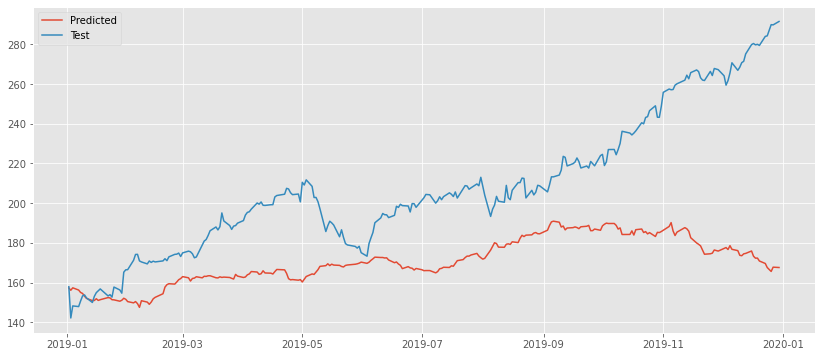

In [69]:
plt.figure(figsize=(14,6))
plt.plot(pred5, label='Predicted')
plt.plot(test, label='Test')
plt.legend(loc='best')
plt.show()

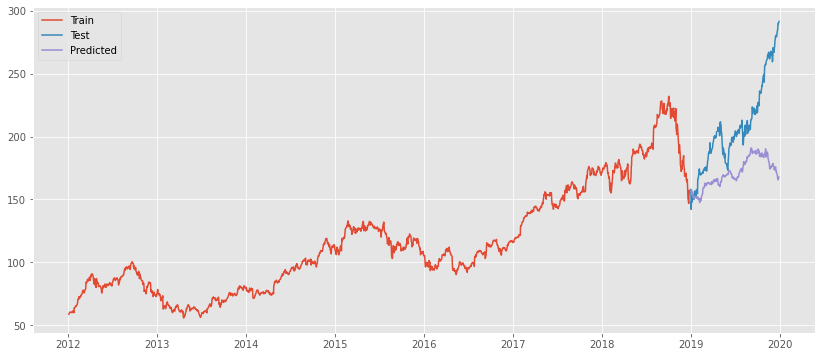

In [70]:
plt.figure(figsize=(14,6))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(pred5, label='Predicted')
plt.legend(loc='best')
plt.show()

In [71]:
rmse4 = sqrt(mean_squared_error(pred5,test))

print('Root Mean Squared Error of Holt Winters Triple Exponential Smoothing =',rmse4)

Root Mean Squared Error of Holt Winters Triple Exponential Smoothing = 46.09078834994371


# Summarizing :


In [72]:
data1 = {'Models':['ARIMA','ARIMA with Seanonal oder','SARIMA with Quaterly Seasonality',
                   'SARIMA with MONTHLY Seasonality ',
                   ],
       'Root Mean Squared Error':[rmse,rmse1,rmse2,rmse3]}
Model = pd.DataFrame(data1)
Model = Model.sort_values('Root Mean Squared Error').reset_index(drop=True)
Model

,Models,Root Mean Squared Error
0,SARIMA with MONTHLY Seasonality,45.869440
1,SARIMA with Quaterly Seasonality,51.036596
2,ARIMA with Seanonal oder,59.061526
3,ARIMA,60.429268


# Training the best model on the whole dataset to forecast :

# Arima with Seasonal order :

In [73]:
model_se1 = sm.tsa.arima.ARIMA(df,order=(1,1,1),seasonal_order=(1,1,1,251))
model_se1 = model_se1.fit(method='innovations_mle',low_memory=True,cov_type='none')
model_se1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             Close   No. Observations:                 1995
Model:             ARIMA(1, 1, 1)x(1, 1, 1, 251)   Log Likelihood               -4062.206
Date:                           Thu, 16 Feb 2023   AIC                           8134.412
Time:                                   12:40:30   BIC                           8161.729
Sample:                               01-03-2012   HQIC                          8144.512
                                    - 12-30-2019                                         
Covariance Type:                    Not computed                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8595        nan        nan        nan         nan         nan
ma.L1          0.8818        nan        nan        nan         nan         nan
ar.S.L251     -0.0820        nan        nan        nan         nan         nan
ma.S.L251     -0.7318        nan        nan        nan         nan         nan
sigma2         5.4532        nan        nan        nan         nan         nan
===================================================================================
Ljung-Box (L1) (Q):                   0.12   Jarque-Bera (JB):              2196.44
Prob(Q):                              0.73   Prob(JB):                         0.00
Heteroskedasticity (H):               4.03   Skew:                            -0.43
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.43
===================================================================================

Warnings:
[1] Covariance matrix not calculated.
"""

# Forecast for next 30 days 

In [74]:
f = pd.DataFrame(model_se1.forecast(30))
f

,predicted_mean
2019-12-31,290.523309
2020-01-02,291.082980
2020-01-03,291.357951
2020-01-06,287.658312
2020-01-07,290.045022
2020-01-08,289.489202
2020-01-09,289.811463
2020-01-10,290.408154
2020-01-13,290.077221
2020-01-14,289.504141


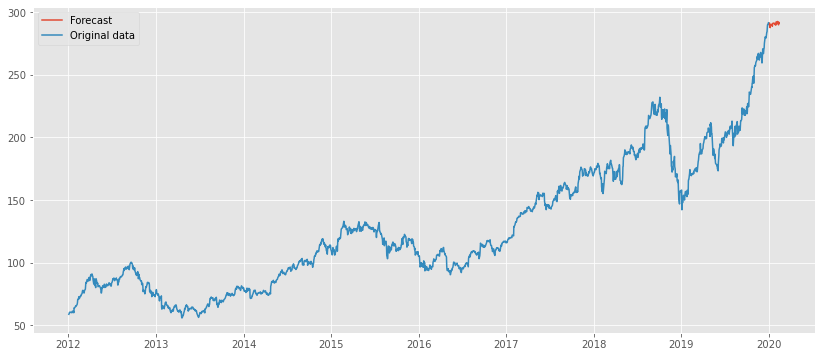

In [75]:
plt.figure(figsize=(14,6))
plt.plot(f, label='Forecast')
plt.plot(df, label='Original data')
plt.legend(loc='best')
plt.show()

# Saving the best model :

# Arima with Seasonal order :

In [76]:
filename = 'model_trained.pkl'

In [77]:
pickle.dump(model_se1,open(filename,'wb'))
 